# Preemption and Execution Intervals

This notebook illustrates the intervals that contain preemptions logged by Joshua's preemption logger.

In [1]:
import os
%cd ~/Desktop/Research/GPU-research/Preemptions/Xavier

custom_directory_path = 'FourCustomCapacity'
custom_paths = []

# List all files in the custom carveout directory
for filename in os.listdir(custom_directory_path):
  if filename == '.DS_Store':
    continue
  file_path = os.path.join(custom_directory_path, filename)
  if os.path.isfile(file_path):
      custom_paths.append(file_path)

# Order the paths so that the arrays have the capacities in the same order for plotting
custom_paths = sorted(custom_paths)
print(custom_paths)

/Users/alexgeorgiev/Desktop/Research/GPU-research/Preemptions/Xavier
['FourCustomCapacity/CxavierSetSharedThree12th.csv', 'FourCustomCapacity/FxavierSetSharedSix12th.csv', 'FourCustomCapacity/IxavierSetSharedNine12th.csv', 'FourCustomCapacity/LxavierSetSharedTwelve12th.csv']


### Load in the data

In [11]:
import pandas as pd
import numpy as np
%cd ~/Desktop/Research/GPU-research/Preemptions
from analyzer_functions import *
%cd ~/Desktop/Research/GPU-research/Preemptions/Xavier

dataPath = custom_paths[3]

intervals = data_loader(singlePath=dataPath, onlyPreemptIvls=True, single=True)

# convert to microseconds
intervals = np.array(intervals) / 1000

# export to CSV
# np.savetxt("preempts.csv", intervals, delimiter=",")

/Users/alexgeorgiev/Desktop/Research/GPU-research/Preemptions
/Users/alexgeorgiev/Desktop/Research/GPU-research/Preemptions/Xavier


In [12]:
# load in the csv as a dataframe
import pandas as pd
times = pd.read_csv(dataPath, header=None)

times.columns = ['start', 'end']

times['interval'] = times['end'] - times['start']

In [13]:
times.head()

,start,end,interval
0,5364143506584209,5364146003560609,2496976400
1,5364146005413198,5364146006430125,1016927
2,5364146008105545,5364146009126569,1021024
3,5364146010407712,5364146011427711,1019999
4,5364146011646868,5364146013696083,2049215


## Plot the raw times

ValueError: x and y must be the same size

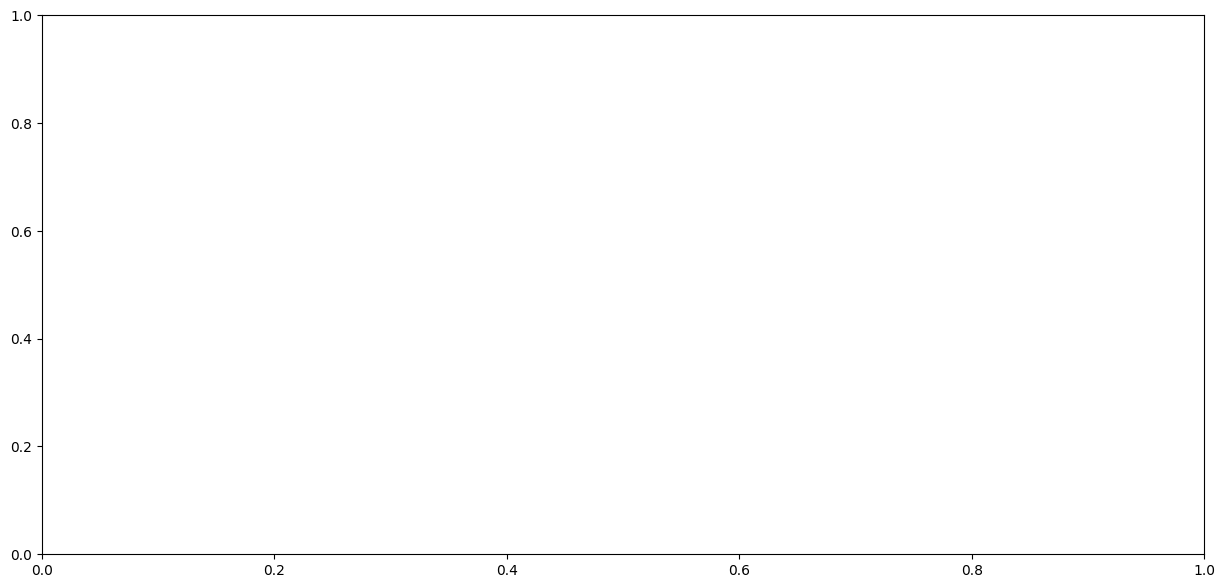

In [ ]:
import matplotlib.pyplot as plt
NUM_SAMPLES = 1000000
# make the figure
plt.figure(figsize=(15, 7))

# plot the raw times
plt.scatter(range(1, NUM_SAMPLES+1), times)

In [ ]:
len(times) == len(range(1, NUM_SAMPLES+1))

True

## Plot the intervals

In [ ]:
#!/usr/bin/env python3
import matplotlib.pyplot as plt
import numpy
import sys
plt.rcParams["figure.figsize"] = (16,2)
plt.rcParams["axes.formatter.useoffset"] = False

# Google Drive colors
dark_orange = '#e69138'
dark_blue = '#3d85c6'
dark_green = '#6aa84f'

np = numpy
def autoscale(ax=None, axis='y', margin=0.1):
    '''Autoscales the x or y axis of a given matplotlib ax object
    to fit the margins set by manually limits of the other axis,
    with margins in fraction of the width of the plot

    Defaults to current axes object if not specified.
    '''

    
    if ax is None:
        ax = plt.gca()
    newlow, newhigh = np.inf, -np.inf

    for artist in ax.collections + ax.lines:
        x,y = get_xy(artist)
        if axis == 'y':
            setlim = ax.set_ylim
            lim = ax.get_xlim()
            fixed, dependent = x, y
        else:
            setlim = ax.set_xlim
            lim = ax.get_ylim()
            fixed, dependent = y, x

        low, high = calculate_new_limit(fixed, dependent, lim)
        newlow = low if low < newlow else newlow
        newhigh = high if high > newhigh else newhigh

    margin = margin*(newhigh - newlow)

    setlim(newlow-margin, newhigh+margin)

def calculate_new_limit(fixed, dependent, limit):
    '''Calculates the min/max of the dependent axis given 
    a fixed axis with limits
    '''
    if len(fixed) > 2:
        mask = (fixed>limit[0]) & (fixed < limit[1]) & (~np.isnan(dependent)) & (~np.isnan(fixed))
        window = dependent[mask]
        try:
            low, high = window.min(), window.max()
        except ValueError:  # Will throw ValueError if `window` has zero elements
            low, high = np.inf, -np.inf
    else:
        low = dependent[0]
        high = dependent[-1]
        if low == 0.0 and high == 1.0:
            # This is a axhline in the autoscale direction
            low = np.inf
            high = -np.inf
    return low, high

def get_xy(artist):
    '''Gets the xy coordinates of a given artist
    '''
    if "Collection" in str(artist):
        x, y = artist.get_offsets().T
    elif "Line" in str(artist):
        x, y = artist.get_xdata(), artist.get_ydata()
    else:
        raise ValueError("This type of object isn't implemented yet")
    return x, y

def plot_ivls(ivls, markers=[], lim=None, save=None):
    base = ivls[0][0]

    # Rebase everything such that 0 = time of first run interval
    markers -= base
    markers /= 1000*1000 # Convert ns to ms
    ivls -= base
    ivls /= 1000*1000 # Convert ns to ms
    

    # Mush the run intervals into a format we can pass to plot
    # Do this by inserting None between the end of one interval and the start of
    # the next, allowing us to plot all intervals with a single plot() call as
    # though it's one long line
    ivls = numpy.append(ivls, numpy.full((ivls.shape[0], 1), float('nan')), axis = 1);
    flat_ivls = ivls.flatten()
    
    y_idxs = numpy.copy(ivls)
    y_idxs[:,0] = numpy.arange(ivls.shape[0])
    y_idxs[:,1] = numpy.arange(ivls.shape[0])
    flat_y_idxs = y_idxs.flatten()

    fig, ax = plt.subplots()
    ax.set_xlabel("Time [milliseconds (ms)]")
    ax.set_ylabel("Timeslice Number")
    ax.ticklabel_format(style='plain')
    ax.plot(flat_ivls, flat_y_idxs, c=dark_blue, solid_capstyle='butt')
    #ax.plot(markers, numpy.ones(markers.size), "r+")
    for marker in markers:
        plt.axvline(marker, linestyle=':', c=dark_green)
    # Auto-range to shortly before first timeslice to shortly after the end of the last, if no range specified
    if lim:
        plt.xlim(lim)
        autoscale(ax, 'y')
        print(np.interp(lim[0], flat_ivls, flat_y_idxs))
        #plt.ylim(())
    elif lim is None:
        plt.xlim(ivls[0][1]-100, ivls[-1][1]+100)
    plt.tight_layout()
    if save:
        plt.savefig(save)
    plt.show()


if (len(sys.argv) < 2):
    print("Usage: " + sys.argv[0] + " <intervals_log> <markers log>")
    print("<intervals log> is usually the output of preemption_logger")
    print("<markers log> is usually the preemption points")
    exit(1)
ivls = numpy.loadtxt(sys.argv[1], delimiter=",")
markers = []
if (len(sys.argv) == 3):
	markers = numpy.loadtxt(sys.argv[2])

plot_ivls(ivls, markers)